# Manual Regard on Elastic Mill Spring

In [ ]:
# only for Google Colab
!wget -N "https://raw.githubusercontent.com/Institute-of-Metal-Forming/notebooks-ilsenburg/refs/heads/main/requirements.txt"
!wget -N "https://raw.githubusercontent.com/Institute-of-Metal-Forming/notebooks-ilsenburg/refs/heads/main/elastic-mill-spring/Auffederung.png"
!pip install -r "requirements.txt"

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np

import pyroll.basic as pr
import pyroll.export as pe
from scipy.optimize import root_scalar

## Modeling the Elastic Mill Spring

The mill stand is usually treated as rigid, which is not the reality. To be more accurate, the mill stand should be treated as a system of springs, which includes the mill stand itself, the parts for the bearing of the rolls and the rolls themselves. Their principal reaction can be seen in the following diagram for defined mill. But the amplitude of this phenomenon is different from mill stand to mill stand and needs to be specified for each of those. The mills elastic response is quite complex, so we usually apply simplified models with empirically fitted coefficients.

![](Auffederung.png)

For this example case the system of springs is simplified as a single spring constant $C_\mathrm{S}$ in dependence on the rolling force $F_\mathrm{R}$ (for example through previous calculations) being available the real roll gap $s_1$ can be, according to Weber, calculated by:
$$s_1 = s_0 + \frac{F_\mathrm{R}}{C_\mathrm{S}}$$

Or inverted:
$$ F_\mathrm{S} = C_\mathrm{S} \cdot (s_1 - s_0) $$

## Definition of the Rolling Process Using PyRolL

We define an initial workpiece.

In [2]:
in_profile = pr.Profile.box(
    height=4e-3,
    width=50e-3,
    corner_radius=0,
    temperature=25 + 273.15,
    strain=0,
    material="C45",
    density=7.5e3,
    specific_heat_capacity=690,
)
in_profile

BoxProfile(
    classifiers={'box'},
    corner_radius=0,
    cross_section=Polygon(
        area=0.0002,
        height=0.004,
        perimeter=0.10800000000000001,
        width=0.05,
        ),
    density=7500.0,
    material='C45',
    specific_heat_capacity=690,
    strain=0,
    t=0,
    temperature=298.15,
    )

The roll pass is given by a factory function that has the *current* roll gap as parameter. 

In [3]:
def roll_pass(roll_gap):
    return pr.RollPass(
        label="Flach Sack I",
        roll=pr.Roll(
            groove=pr.FlatGroove(
                usable_width=250e-3,
            ),
            nominal_radius=150e-3,
        ),
        gap=roll_gap,
        velocity=0.1,
        coulomb_friction_coefficient=0.2,
    )

The nominal roll gap is the roll gap set on the mill without any load ($s_0$).

In [4]:
nominal_roll_gap = 2e-3

## Calculating the Roll Force's Dependence on the Roll Gap

We create a data frame and fill it with the roll gaps where the simulations shall be conducted, from nominal roll gap up to the initial height of the workpiece (zero draught). Zero draught will not be simulated as this would mean undefined results due to division by zero in some models (`endpoint=False`).

In [5]:
df = pd.DataFrame({"roll_gap": np.linspace(nominal_roll_gap, in_profile.height, 100, endpoint=False)})
df

,roll_gap
0,0.00200
1,0.00202
2,0.00204
3,0.00206
4,0.00208
...,...
95,0.00390
96,0.00392
97,0.00394
98,0.00396


Then we simulate rolling at all these roll gaps to obtain the respective roll forces. This may take a while depending on the used models. Some warnings due to failed convergence at the boundaries of this interval are to be expected.

In [6]:
for i in df.index:
    roll_gap = df["roll_gap"][i]
    print(roll_gap)
    rp = roll_pass(roll_gap)
    rp.solve(in_profile)
    df.loc[i, "roll_force"] = rp.roll_force 

0.002
0.00202
0.00204
0.00206
0.0020800000000000003
0.0021
0.00212
0.00214
0.00216
0.00218
0.0022
0.00222
0.0022400000000000002
0.00226
0.00228
0.0023
0.00232
0.00234
0.00236
0.00238
0.0024000000000000002
0.0024200000000000003
0.00244
0.00246
0.00248
0.0025
0.00252
0.00254
0.00256
0.00258
0.0026
0.00262
0.00264
0.00266
0.00268
0.0027
0.00272
0.0027400000000000002
0.0027600000000000003
0.0027800000000000004
0.0028
0.00282
0.00284
0.00286
0.00288
0.0029000000000000002
0.00292
0.00294
0.00296
0.00298
0.003
0.00302
0.00304
0.0030600000000000002
0.0030800000000000003
0.0031000000000000003
0.0031200000000000004
0.0031400000000000004
0.00316
0.00318
0.0032
0.00322
0.00324
0.00326
0.00328
0.0033
0.00332
0.00334
0.00336
0.00338
0.0034000000000000002
0.0034200000000000003
0.0034400000000000003
0.0034600000000000004
0.0034800000000000005
0.0035
0.00352
0.00354
0.0035600000000000002
0.00358
0.0036
0.00362
0.00364
0.00366
0.00368
0.0037
0.00372
0.0037400000000000003
0.0037600000000000003
0.00378000

The data frame now stores the obtained roll forces.

In [7]:
df

,roll_gap,roll_force
0,0.00200,2.354951e+06
1,0.00202,2.346612e+06
2,0.00204,2.335699e+06
3,0.00206,2.325179e+06
4,0.00208,2.314517e+06
...,...,...
95,0.00390,3.518521e+05
96,0.00392,3.072314e+05
97,0.00394,2.589686e+05
98,0.00396,2.048466e+05


We plot the roll force over the roll gap.

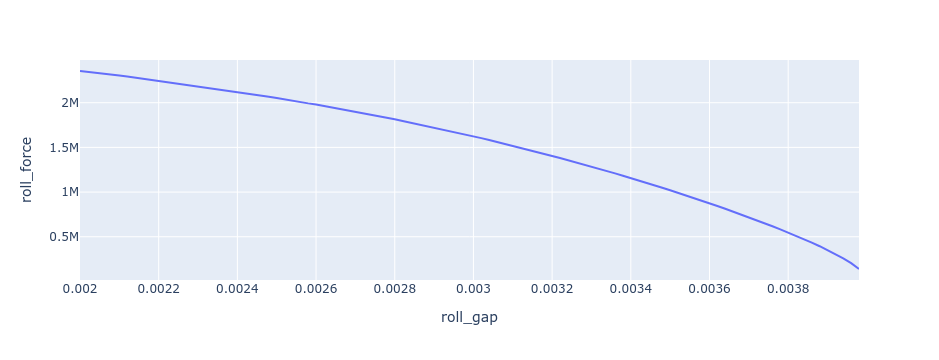

In [8]:
px.line(df, x="roll_gap", y="roll_force")

### Calculating the Mill Spring

As stated above, we approximate the mill spring by a linear spring model. We define the spring force depending on the roll gap widening (`delta_s`).

In [9]:
def mill_spring_force(delta_s):
    """Characteristic curve of mill spring."""
    return 704.1e7 * delta_s

We calculate the respective spring force for all of the previously used roll gaps and store the results in the same data frame.

In [11]:
df["spring_force"] = mill_spring_force(df.roll_gap - nominal_roll_gap)
df

,roll_gap,roll_force,spring_force
0,0.00200,2.354951e+06,0.0
1,0.00202,2.346612e+06,140820.0
2,0.00204,2.335699e+06,281640.0
3,0.00206,2.325179e+06,422460.0
4,0.00208,2.314517e+06,563280.0
...,...,...,...
95,0.00390,3.518521e+05,13377900.0
96,0.00392,3.072314e+05,13518720.0
97,0.00394,2.589686e+05,13659540.0
98,0.00396,2.048466e+05,13800360.0


As the mill spring curve is much steaper, axis scaling is unfortunate.

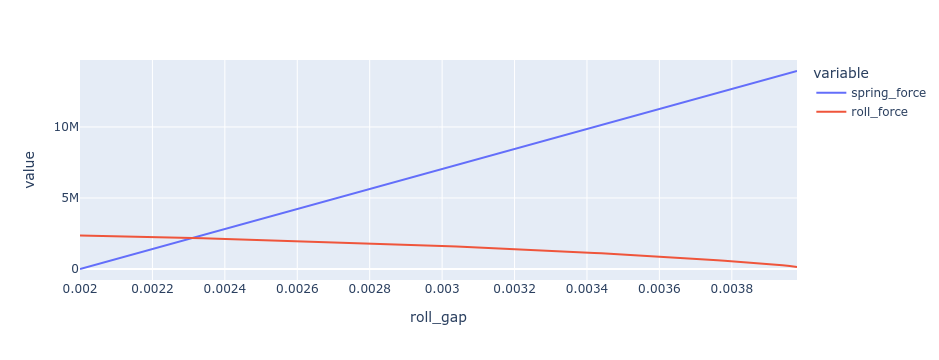

In [12]:
px.line(df, x="roll_gap", y=["spring_force", "roll_force"])

We mask the spring forces higher than the maximum roll force by replacing them with `NA` (not available).

In [13]:
df["spring_force_masked"] = df.spring_force
df.loc[df.spring_force > df.roll_force.max(), "spring_force_masked"] = pd.NA
df

,roll_gap,roll_force,spring_force,spring_force_masked
0,0.00200,2.354951e+06,0.0,0.0
1,0.00202,2.346612e+06,140820.0,140820.0
2,0.00204,2.335699e+06,281640.0,281640.0
3,0.00206,2.325179e+06,422460.0,422460.0
4,0.00208,2.314517e+06,563280.0,563280.0
...,...,...,...,...
95,0.00390,3.518521e+05,13377900.0,NaN
96,0.00392,3.072314e+05,13518720.0,NaN
97,0.00394,2.589686e+05,13659540.0,NaN
98,0.00396,2.048466e+05,13800360.0,NaN


Plotting those masked values, the plot looks much nicer.

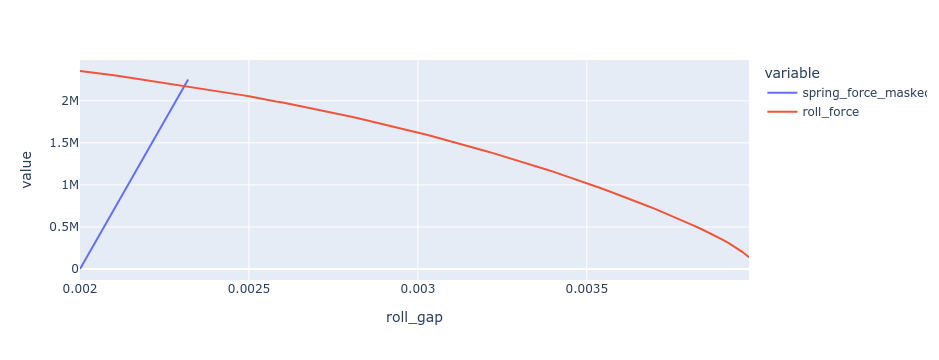

In [14]:
px.line(df, x="roll_gap", y=["spring_force_masked", "roll_force"])

We may calculate the intersection numerically using the `root_scalar` function of scipy. We interpolate our simulation results. For the mill spring, we directly use the analytical expression.

In [16]:
root_scalar(
    lambda s: np.interp(s, df.roll_gap, df.roll_force) - mill_spring_force(s - nominal_roll_gap),
    bracket=[nominal_roll_gap, in_profile.height]
)

      converged: True
           flag: converged
 function_calls: 7
     iterations: 6
           root: 0.0023097628322930356
         method: brentq